##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
!pip install -q tf-models-official==2.3.0

### Imports

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [4]:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

You can get a pre-trained BERT encoder from [TensorFlow Hub](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2):

In [5]:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

In [6]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

The `config` defines the core BERT Model, which is a Keras model to predict the outputs of `num_classes` from the inputs with maximum sequence length `max_seq_length`.

This function returns both the encoder and the classifier.

In [7]:
max_seq_length = 128
initializer = tf.keras.initializers.TruncatedNormal(
        stddev=bert_config.initializer_range)
bert_encoder = bert.bert_models.get_transformer_encoder(
    bert_config, max_seq_length)

input_word_ids = tf.keras.layers.Input(
  shape=(max_seq_length,), dtype=tf.int32, name='input_word_ids')
input_mask = tf.keras.layers.Input(
  shape=(max_seq_length,), dtype=tf.int32, name='input_mask')
input_type_ids = tf.keras.layers.Input(
  shape=(max_seq_length,), dtype=tf.int32, name='input_type_ids')
bert_model = hub.KerasLayer(hub_url_bert, trainable=True)
pooled_output, seq_output = bert_model([input_word_ids, input_mask, input_type_ids])
output1 = tf.keras.layers.Dropout(rate=bert_config.hidden_dropout_prob)(
  pooled_output)

output1 = tf.keras.layers.Dense(
  2, kernel_initializer=initializer, name='output1')(
      output1)

output2 = tf.keras.layers.Dropout(rate=bert_config.hidden_dropout_prob)(
  pooled_output)

output2 = tf.keras.layers.Dense(
  3, kernel_initializer=initializer, name='output2')(
      output2)

model = tf.keras.Model(
      inputs={
          'input_word_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs=[output1, output2])

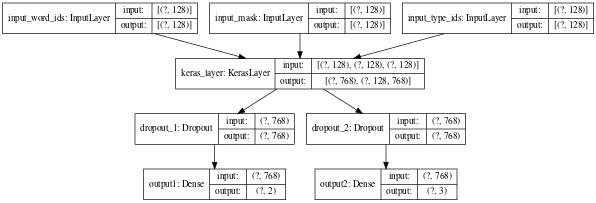

In [8]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [9]:
#tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

In [10]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

# get train_data_size from metadata
train_data_size = 1000
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [11]:
type(optimizer)

official.nlp.optimization.AdamWeightDecay

In [12]:
# def create_classifier_dataset(file_path, seq_length, batch_size, is_training):
#   """Creates input dataset from (tf)records files for train/eval."""
#   dataset = tf.data.TFRecordDataset(file_path)
#   if is_training:
#     dataset = dataset.shuffle(100)
#     dataset = dataset.repeat()

#   def decode_record(record):
#     name_to_features = {
#       'is_real_example': tf.io.FixedLenFeature([], tf.int64),
#       'input_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
#       'input_mask': tf.io.FixedLenFeature([seq_length], tf.int64),
#       'segment_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
#       'label_ids': tf.io.FixedLenFeature([], tf.int64),
#       'example_id': tf.io.FixedLenFeature([], tf.int64),
#     }    
#     return tf.io.parse_single_example(record, name_to_features)

#   def _select_data_from_record(record):
#     return ({
#         'input_word_ids': record['input_ids'],
#         'input_mask': record['input_mask'],
#         'input_type_ids': record['segment_ids']
#     }, (record['label_ids'], -tf.ones([seq_length], dtype=tf.int64)))

#   dataset = dataset.map(decode_record,
#                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
#   dataset = dataset.map(
#       _select_data_from_record,
#       num_parallel_calls=tf.data.experimental.AUTOTUNE)
#   # dataset = dataset.batch(batch_size, drop_remainder=is_training)
#   dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
#   return dataset

In [13]:
# def create_classifier_dataset(file_path, seq_length, batch_size, is_training):
#   """Creates input dataset from (tf)records files for train/eval."""
#   dataset = tf.data.TFRecordDataset(file_path)
#   if is_training:
#     dataset = dataset.shuffle(100)
#     dataset = dataset.repeat()

#   def decode_record(record):
#     name_to_features = {
#       'input_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
#       'input_mask': tf.io.FixedLenFeature([seq_length], tf.int64),
#       'segment_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
#       'label_ids': tf.io.FixedLenFeature([], tf.int64),
#     }
#     return tf.io.parse_single_example(record, name_to_features)

#   def _select_data_from_record(record):
#     x = {
#         'input_word_ids': record['input_ids'],
#         'input_mask': record['input_mask'],
#         'input_type_ids': record['segment_ids']
#     }
#     y = record['label_ids']
#     return (x, y)

#   dataset = dataset.map(decode_record,
#                         num_parallel_calls=tf.data.experimental.AUTOTUNE)
#   dataset = dataset.map(
#       _select_data_from_record,
#       num_parallel_calls=tf.data.experimental.AUTOTUNE)
#   #dataset = dataset.batch(batch_size, drop_remainder=is_training)
#   dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
#   return dataset

In [14]:
def create_tagging_dataset(file_path, seq_length, batch_size, is_training):
  """Creates input dataset from (tf)records files for train/eval."""
  dataset = tf.data.TFRecordDataset(file_path)
  if is_training:
    dataset = dataset.shuffle(100)
    dataset = dataset.repeat()

  def decode_record(record):
    name_to_features = {
      'input_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
      'input_mask': tf.io.FixedLenFeature([seq_length], tf.int64),
      'segment_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
      'label_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
      'sub_sentence_id': tf.io.FixedLenFeature([], tf.int64),
      'sentence_id': tf.io.FixedLenFeature([], tf.int64),
    }    
    return tf.io.parse_single_example(record, name_to_features)

  def _select_data_from_record(record):
    return ({
        'input_word_ids': record['input_ids'],
        'input_mask': record['input_mask'],
        'input_type_ids': record['segment_ids']
    }, (-tf.ones([], dtype=tf.int64), record['label_ids']))

  dataset = dataset.map(decode_record,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      _select_data_from_record,
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  # dataset = dataset.batch(batch_size, drop_remainder=is_training)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

In [15]:
from typing import Mapping, Optional

import dataclasses
import tensorflow as tf

from official.core import input_reader
from official.modeling.hyperparams import config_definitions as cfg
from official.nlp.data import data_loader
from official.nlp.data import data_loader_factory


@dataclasses.dataclass
class TaggingDataConfig(cfg.DataConfig):
  """Data config for tagging (tasks/tagging)."""
  is_training: bool = True
  seq_length: int = 128
  include_sentence_id: bool = False


@data_loader_factory.register_data_loader_cls(TaggingDataConfig)
class TaggingDataLoader(data_loader.DataLoader):
  """A class to load dataset for tagging (e.g., NER and POS) task."""

  def __init__(self, params: TaggingDataConfig):
    self._params = params
    self._seq_length = params.seq_length
    self._include_sentence_id = params.include_sentence_id

  def _decode(self, record: tf.Tensor):
    """Decodes a serialized tf.Example."""
    name_to_features = {
        'input_ids': tf.io.FixedLenFeature([self._seq_length], tf.int64),
        'input_mask': tf.io.FixedLenFeature([self._seq_length], tf.int64),
        'segment_ids': tf.io.FixedLenFeature([self._seq_length], tf.int64),
        'label_ids': tf.io.FixedLenFeature([self._seq_length], tf.int64),
    }
    if self._include_sentence_id:
      name_to_features['sentence_id'] = tf.io.FixedLenFeature([], tf.int64)
      name_to_features['sub_sentence_id'] = tf.io.FixedLenFeature([], tf.int64)

    example = tf.io.parse_single_example(record, name_to_features)

    # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
    # So cast all int64 to int32.
    for name in example:
      t = example[name]
      if t.dtype == tf.int64:
        t = tf.cast(t, tf.int32)
      example[name] = t

    return example

  def _parse(self, record: Mapping[str, tf.Tensor]):
    """Parses raw tensors into a dict of tensors to be consumed by the model."""
    x = {
        'input_word_ids': record['input_ids'],
        'input_mask': record['input_mask'],
        'input_type_ids': record['segment_ids']
    }
    if self._include_sentence_id:
      x['sentence_id'] = record['sentence_id']
      x['sub_sentence_id'] = record['sub_sentence_id']

    y = record['label_ids']
    return (x, y)

  def load(self, input_context: Optional[tf.distribute.InputContext] = None):
    """Returns a tf.dataset.Dataset."""
    reader = input_reader.InputReader(
        params=self._params, decoder_fn=self._decode, parser_fn=self._parse)
    return reader.read(input_context)

In [16]:
def single_file_dataset(input_file, name_to_features, num_samples=None):
  """Creates a single-file dataset to be passed for BERT custom training."""
  # For training, we want a lot of parallel reading and shuffling.
  # For eval, we want no shuffling and parallel reading doesn't matter.
  d = tf.data.TFRecordDataset(input_file)
  if num_samples:
    d = d.take(num_samples)
  d = d.map(
      lambda record: decode_record(record, name_to_features),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # When `input_file` is a path to a single file or a list
  # containing a single path, disable auto sharding so that
  # same input file is sent to all workers.
  if isinstance(input_file, str) or len(input_file) == 1:
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = (
        tf.data.experimental.AutoShardPolicy.OFF)
    d = d.with_options(options)
  return d

In [17]:
def decode_record(record, name_to_features):
  """Decodes a record to a TensorFlow example."""
  example = tf.io.parse_single_example(record, name_to_features)

  # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
  # So cast all int64 to int32.
  for name in list(example.keys()):
    t = example[name]
    if t.dtype == tf.int64:
      t = tf.cast(t, tf.int32)
    example[name] = t

  return example

In [18]:
import pdb

In [19]:
def create_classifier_dataset(file_path,
                              seq_length,
                              batch_size,
                              task_id,
                              is_training=True,
                              input_pipeline_context=None,
                              label_type=tf.int64,
                              include_sample_weights=False,
                              num_samples=None):
  """Creates input dataset from (tf)records files for train/eval."""
  name_to_features = {
      'input_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
      'input_mask': tf.io.FixedLenFeature([seq_length], tf.int64),
      'segment_ids': tf.io.FixedLenFeature([seq_length], tf.int64),
      'label_ids': tf.io.FixedLenFeature([], label_type),
  }
  if include_sample_weights:
    name_to_features['weight'] = tf.io.FixedLenFeature([], tf.float32)
  dataset = single_file_dataset(file_path, name_to_features,
                                num_samples=num_samples)

  # The dataset is always sharded by number of hosts.
  # num_input_pipelines is the number of hosts rather than number of cores.
  if input_pipeline_context and input_pipeline_context.num_input_pipelines > 1:
    dataset = dataset.shard(input_pipeline_context.num_input_pipelines,
                            input_pipeline_context.input_pipeline_id)

  def _select_data_from_record(record):
    x = {
        'input_word_ids': record['input_ids'],
        'input_mask': record['input_mask'],
        'input_type_ids': record['segment_ids']
    }
    #pdb.set_trace()
    y = record['label_ids']
    if include_sample_weights:
      w = record['weight']
      return (x, y, w)
    default = tf.constant(-1, dtype=tf.int32)
    if task_id ==0:
      return (x, [y, default])
    if task_id == 1:
      return (x, [default,y])

  if is_training:
    dataset = dataset.shuffle(100)
    dataset = dataset.repeat()

  dataset = dataset.map(
      _select_data_from_record,
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  #dataset = dataset.batch(batch_size, drop_remainder=is_training)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

### Data sampling (using proportional sampling technique)

In [20]:
tf_records_filenames = ["gs://nts2020/xtereme/pawsx/train.en.tfrecords", "gs://nts2020/xtereme/xnli/train.en.tfrecords"]

sampling_factor = []
for fn in tf_records_filenames:
    c = 0
    for record in tf.compat.v1.python_io.tf_record_iterator(fn):
        c += 1
    sampling_factor.append(c)
    print(c)
c = sum(sampling_factor)
for i in range(0, len(sampling_factor)):
    sampling_factor[i] = sampling_factor[i]/c
sampling_factor

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


49401
392702


[0.11174092914999446, 0.8882590708500055]

In [21]:
# Set up batch sizes
batch_size = 64
eval_batch_size = 64

# Return Tensorflow dataset
paws_training_dataset = create_classifier_dataset(
    "gs://nts2020/xtereme/pawsx/train.en.tfrecords",
    128,
    batch_size,
    task_id = 0,
    is_training=True)

xnli_training_dataset = create_classifier_dataset(
    "gs://nts2020/xtereme/xnli/train.en.tfrecords",
    128,
    batch_size,
    task_id = 1,
    is_training=True)


In [22]:
paws_training_dataset.element_spec

({'input_word_ids': TensorSpec(shape=(128,), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(128,), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(128,), dtype=tf.int32, name=None)},
 TensorSpec(shape=(2,), dtype=tf.int32, name=None))

In [23]:
xnli_training_dataset.element_spec

({'input_word_ids': TensorSpec(shape=(128,), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(128,), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(128,), dtype=tf.int32, name=None)},
 TensorSpec(shape=(2,), dtype=tf.int32, name=None))

In [24]:
training_dataset = tf.data.experimental.sample_from_datasets(
    [paws_training_dataset, xnli_training_dataset], weights=tf.constant([sampling_factor[0], sampling_factor[1]])
)

In [25]:
paws_eval_dataset = create_classifier_dataset(
    "gs://nts2020/xtereme/pawsx/eval.en.tfrecords",
    128,
    batch_size,
    task_id = 0,
    is_training=True)

In [26]:
xnli_eval_dataset = create_classifier_dataset(
    "gs://nts2020/xtereme/xnli/eval.en.tfrecords",
    128,
    batch_size,
    task_id =1,
    is_training=True)

In [27]:
evaluation_dataset = tf.data.experimental.sample_from_datasets(
    [paws_eval_dataset, xnli_eval_dataset], weights=tf.constant([sampling_factor[0], sampling_factor[1]])
)

In [28]:
training_dataset.element_spec

({'input_word_ids': TensorSpec(shape=(128,), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(128,), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(128,), dtype=tf.int32, name=None)},
 TensorSpec(shape=(2,), dtype=tf.int32, name=None))

In [29]:
paws_eval_dataset.element_spec

({'input_word_ids': TensorSpec(shape=(128,), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(128,), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(128,), dtype=tf.int32, name=None)},
 TensorSpec(shape=(2,), dtype=tf.int32, name=None))

In [30]:
xnli_eval_dataset.element_spec

({'input_word_ids': TensorSpec(shape=(128,), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(128,), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(128,), dtype=tf.int32, name=None)},
 TensorSpec(shape=(2,), dtype=tf.int32, name=None))

In [31]:
evaluation_dataset.element_spec

({'input_word_ids': TensorSpec(shape=(128,), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(128,), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(128,), dtype=tf.int32, name=None)},
 TensorSpec(shape=(2,), dtype=tf.int32, name=None))

In [32]:

training_dataset = training_dataset.batch(batch_size)
evaluation_dataset = evaluation_dataset.batch(batch_size)

In [33]:
# tf.config.run_functions_eagerly(True)


In [34]:
# def _loss_with_filter(y_true, y_pred):
#   #pdb.set_trace()
#   num_labels = y_pred.get_shape().as_list()[-1]
#   log_probs = tf.nn.log_softmax(y_pred, axis=-1)
#   log_probs = tf.reshape(log_probs, [-1, num_labels])
#   labels = tf.reshape(y_true, [-1])
    
#   if y_pred.get_shape().as_list()[-1] == 2:
#       one_hot_labels = tf.identity(labels)
#       one_hot_labels = tf.cast(one_hot_labels, tf.float32)  
#   else:
#       one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)
#   per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
#   loss = tf.reduce_mean(per_example_loss)
#   pdb.set_trace()
#   return loss

In [35]:
import pdb

In [36]:
def _loss_mod(y_true, y_pred):
  #pdb.set_trace()
  num_labels = y_pred.get_shape().as_list()[-1]
  task_id = tf.math.argmax(input = y_true[-1])
  #labels = tf.reshape(y_true, [-1])
  one_hot_labels = tf.one_hot(y_true[-1][task_id], depth=num_labels, dtype=tf.float32) 
  #tf.print(one_hot_labels)
  #one_hot_labels = tf.compat.v1.Print(one_hot_labels, [y_true, y_pred], 'output = ', summarize=500)
  log_probs = tf.nn.log_softmax(y_pred, axis=-1)
  per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
  loss = tf.reduce_mean(per_example_loss) 
  #pdb.set_trace()
  return loss

In [ ]:

metrics = [tf.keras.metrics.CategoricalAccuracy('accuracy', dtype=tf.float32)]
loss1 = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer = optimizer, loss = [_loss_mod, _loss_mod], metrics = metrics)
model.fit(training_dataset, batch_size = batch_size, epochs= 3, steps_per_epoch = 1000, validation_data=evaluation_dataset, validation_steps=10)


Epoch 1/3
1000/1000 [==============================] - 1670s 2s/step - loss: 1.6130 - output1_loss: 0.5317 - output2_loss: 1.0813 - output1_accuracy: 0.4548 - output2_accuracy: 0.2606 - val_loss: 1.5781 - val_output1_loss: 0.4172 - val_output2_loss: 1.1610 - val_output1_accuracy: 0.4062 - val_output2_accuracy: 0.1281
Epoch 2/3
 483/1000 [=============>................] - ETA: 14:21 - loss: 1.6035 - output1_loss: 0.4996 - output2_loss: 1.1040 - output1_accuracy: 0.4643 - output2_accuracy: 0.2663

In [ ]:
#metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy1', dtype=tf.float32),
#            tf.keras.metrics.SparseCategoricalAccuracy('accuracy2', dtype=tf.float32)]

metrics = [tf.keras.metrics.CategoricalAccuracy('accuracy', dtype=tf.float32), tf.keras.metrics.]
loss1 = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss2 = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# TODO(henrytsai):
# def _loss_with_filter(y_true, y_pred):
# filters out `-1` labels.

# training_dataset = training_dataset.batch(32)
# model.compile(
#     optimizer=optimizer,
#     # Add more losses here.
#     loss=[loss1, loss2])

training_dataset = training_dataset.batch(32)
# paws_training_dataset = paws_training_dataset.batch(32)
# xnli_training_dataset = xnli_training_dataset.batch(32)
model.compile(optimizer = optimizer, loss = [_loss_with_filter, _loss_with_filter], metrics = metrics)
model.fit(training_dataset, batch_size = 32, epochs= epochs, steps_per_epoch = 1000)
# model.fit(
#       training_dataset,
#       batch_size=32,
#       epochs=epochs,
#       steps_per_epoch=1000)

In [ ]:
paws_training_dataset = paws_training_dataset.batch(2, drop_remainder=True)

In [ ]:
paws_training_dataset = create_classifier_dataset(
    "gs://nts2020/xtereme/pawsx/train.en.tfrecords",
    128,
    batch_size,
    is_training=True)

In [ ]:
udpos_training_dataset = udpos_training_dataset.batch(2)

In [ ]:
for element in paws_training_dataset.as_numpy_iterator():
  print(element)
  break


In [ ]:
for element in xnli_training_dataset.as_numpy_iterator():
  print(element)
  break


In [ ]:
for element in training_dataset.as_numpy_iterator():
  print(element)
  break

In [ ]:
for element in evaluation_dataset.as_numpy_iterator():
  print(element[0]['input_word_ids'].shape)
  break